In [1]:
import numpy as np
from nltk.cluster.util import cosine_distance
from nltk.cluster.kmeans import KMeansClusterer
import matplotlib.pylab as plt
%matplotlib inline

from make_index import build_index, get_vocabulary, build_inverted_index, get_tf_matrix, normalize

In [2]:
dir_path = "./txt/"
index, doc_id_to_path = build_index(dir_path)
vocabulary, term_to_id = get_vocabulary(index)
voc_size = vocabulary.shape[0]
inverted_index = build_inverted_index(index, term_to_id)

num_docs = len(index)
del index

tf_matrix = get_tf_matrix(inverted_index, num_docs)
tf_matrix = normalize(tf_matrix)

In [3]:
print num_docs, "документа"

403 документа


Не нашёл библиотеки, которая позволяла бы делать разложение на 1000 сингулярных чисел (>403). Есть имплементации с параметром full_matrices, но для них не хватает оперативной памяти. Поэтому делаю разложение на размер наименьшей оси (кол-во документов).

In [4]:
%%time
T, S, Dt = np.linalg.svd(tf_matrix, full_matrices=False)

CPU times: user 11.7 s, sys: 2.56 s, total: 14.3 s
Wall time: 2.05 s


Посчитаем и изобразим норму разности истинной нормированной матрицы и восстановленной по неполному сингулярному разложению: $\left \| \hat{A} - \hat{A}_{r} \right \|$ в зависимости от числа взятых сингулярных чисел.

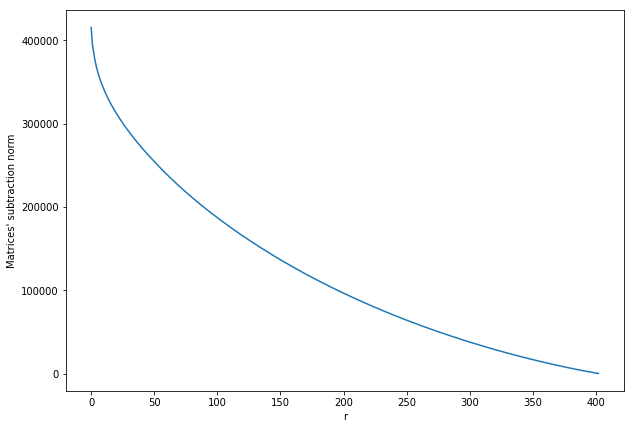

In [5]:
sub_norms = np.cumsum((S**2)[::-1])[::-1]
sub_norms = list(sub_norms[1:]) + [0]

plt.figure(figsize=(10,7))
plt.ylabel("Matrices' subtraction norm")
plt.xlabel("r")
plt.plot(range(num_docs), sub_norms);

Выберем r=403, т.к.

1) на всей длине кривая имеет дост-но большую производную (по модулю)

2) 403 не очень большое число для семантического пространства

Получим представления документов.

In [6]:
r = 403
D_lsi = Dt[:r,:].transpose()

Откластеризуем их.

Я смотрел на названия работ и на топовые (по нормированному tf) слова. Но попытки интерпретировать кластеры оказались тщетны. Поэтому выбрал число кластеров 10.

In [8]:
from utils import STOP_WORDS, get_top_terms
stop_words_ids = [term_to_id[term] for term in STOP_WORDS if term in term_to_id]

top5_terms = get_top_terms(tf_matrix, vocabulary, stop_words_ids, k=5)

In [9]:
def print_clusters(clusters, doc_id_to_path, top_terms = None):
    clusters = np.array(clusters)
    num_clusters = np.unique(clusters).shape[0]
    for c in range(num_clusters):
        print c, "cluster"
        doc_ids = np.where(clusters == c)[0]
        for doc_id in doc_ids:
            doc_path = doc_id_to_path[doc_id]
            if top_terms is None:
                print doc_path[doc_path.find("-") + 1:]
            else:
                print top_terms[doc_id]            
        print

In [10]:
NUM_CLUSTERS = 10

kmeans = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=20)
assigned_clusters = kmeans.cluster(D_lsi, assign_clusters=True)
print_clusters(assigned_clusters, doc_id_to_path)

0 cluster
revenue-optimization-against-strategic-buyers.txt
rethinking-lda-moment-matching-for-discrete-ica.txt
variational-information-maximisation-for-intrinsically-motivated-reinforcement-learning.txt
next-a-system-for-real-world-development-evaluation-and-application-of-active-learning.txt
a-structural-smoothing-framework-for-robust-graph-comparison.txt
the-pareto-regret-frontier-for-bandits.txt
variational-consensus-monte-carlo.txt
inverse-reinforcement-learning-with-locally-consistent-reward-functions.txt
bayesian-active-model-selection-with-an-application-to-automated-audiometry.txt
automatic-variational-inference-in-stan.txt
deep-visual-analogy-making.txt
statistical-topological-data-analysis-a-kernel-perspective.txt
sum-of-squares-lower-bounds-for-sparse-pca.txt
3d-object-proposals-for-accurate-object-class-detection.txt
a-universal-primal-dual-convex-optimization-framework.txt
preconditioned-spectral-descent-for-deep-learning.txt
when-are-kalman-filter-restless-bandits-indexa